In [1]:
# A compléter ici :
# Nom : Andrieu
# Prénom : Ludovic
# N étudiant : 22103219

# Support Vector Machines

Dans ce TP, nous allons étudiers plusieurs aspects des SVM :
- visualiser la frontière de décision,
- reconnaître des chiffres manuscrits,
- chercher les meilleurs hyperparamètres,
- détecter les intrus (outliers).

**Pendant ce TP, vous aurez besoin d'aller lire et d'utiliser la documentation de Scikit-learn sur les SVM: [https://scikit-learn.org/stable/api/sklearn.svm.html](https://scikit-learn.org/stable/api/sklearn.svm.html)**

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn

plt.rcParams['figure.figsize'] = [12, 8]

## 1. Visualisation de la frontière de décision dans les SVM

On va présenter ici deux techniques pour visualiser la frontière de décision d'un SVM. La première est basée sur les fonctions de matplotlib, là où la seconde utilise la classe `DecisionBoundaryDisplay` de scikit-learn.

On commence par générer des données synthétiques: X1 (resp. X2) contient des données 2D, et y1 (resp. y2) contient leurs labels.

In [3]:
from sklearn import datasets
n_samples = 500

seed = 42
X1, y1 = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X2, y2 = datasets.make_moons(
    n_samples=n_samples, noise=0.1, random_state=seed
)

**Q1:** affichez ces deux jeux de données à l'aide de matplotlib (par exemple, avec la fonction scatter).

Les données sont-elles linéairement séparables ?

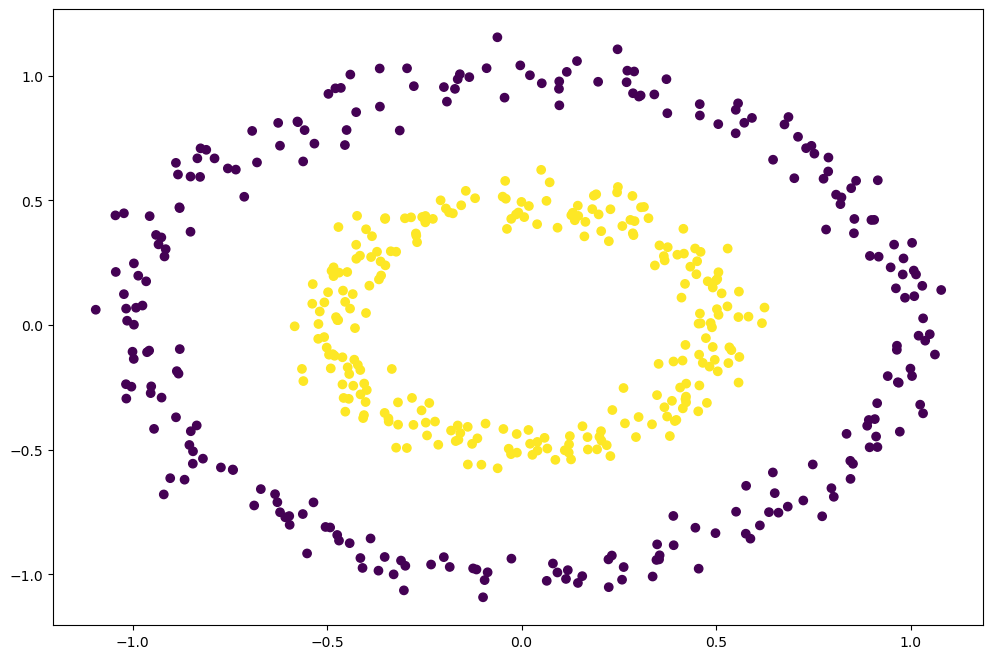

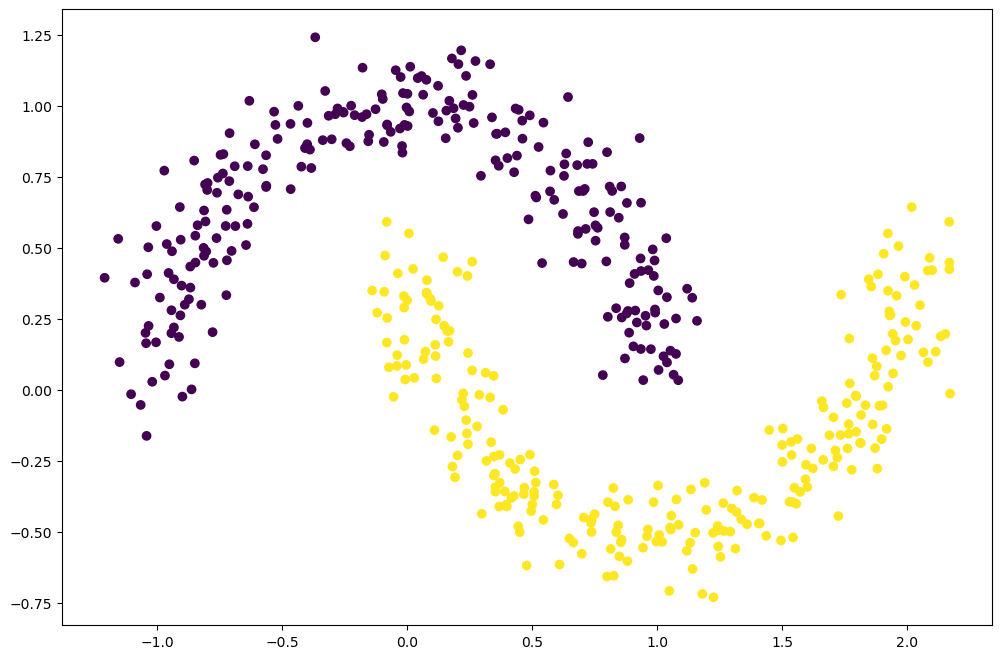

In [4]:
plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.show()
plt.scatter(X2[:, 0], X2[:, 1], c=y2)

Pour le premier jeu de données, on va entraînerun modèle SVM de classification ([svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) dans scikit-learn) avec un kernel polynomial de degré 2.

**Q2:** Quels sont les hyperparamètres de ce modèle ? 

> A compléter ici
ce sont `C` pour la régularization et `coef0` pour le bias du kernel poly

**Q3**: Entraînez ce modèle sur $(X1, y1)$ en utilisant les paramètres correspondant au kernel
$$K(x,y) = (\langle x, y\rangle + 1)^2,$$
et en gardant le paramètre $C$ à sa valeur par défaut de $1.0$.

In [5]:
# A compléter ici
from sklearn.svm import SVC
model1 = SVC(kernel="poly", degree=2, coef0=1.0, C=1.0)

model1.fit(X1, y1)


SVC(coef0=1.0, degree=2, kernel='poly')

**Q4**: en utilisant les fonctions `model.predict`, `plt.contourf` et `np.meshgrid` (mais pas seulement), affichez la frontière de décision du modèle (en transparence), superposées avec les données d'entrée.

Le modèle parvient-il à séparer les données ?

In [6]:
def plotFrontiere(Xranges:list[tuple[float, float]], model:SVC, 
                  res:int, margin:float, alpha:float)->None:
    assert len(Xranges) == 2
    X_raw = np.stack(np.meshgrid(
        *[np.linspace(mini-margin, maxi+margin, num=res) 
          for (mini, maxi) in Xranges]), 
        axis=-1)
    X_model = X_raw.reshape((res**2, 2))
    y_model_net = model.decision_function(X_model)
    y_model_score = model.predict(X_model)
    plt.contourf(X_raw[:, :, 0], X_raw[:, :, 1], y_model_net.reshape((res, res)), alpha=1.0)
    plt.contourf(X_raw[:, :, 0], X_raw[:, :, 1], y_model_score.reshape((res, res)), alpha=0.1)

def plotFrontiere2(X:np.ndarray, y:np.ndarray, model:SVC, 
                   res:int=200, margin:float=0, alpha:float=0.2)->None:
    XRanges = [(X[:, iFeature].min(), X[:, iFeature].max()) for iFeature in range(X.shape[-1])]
    plotFrontiere(XRanges, model, res, margin, alpha)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    

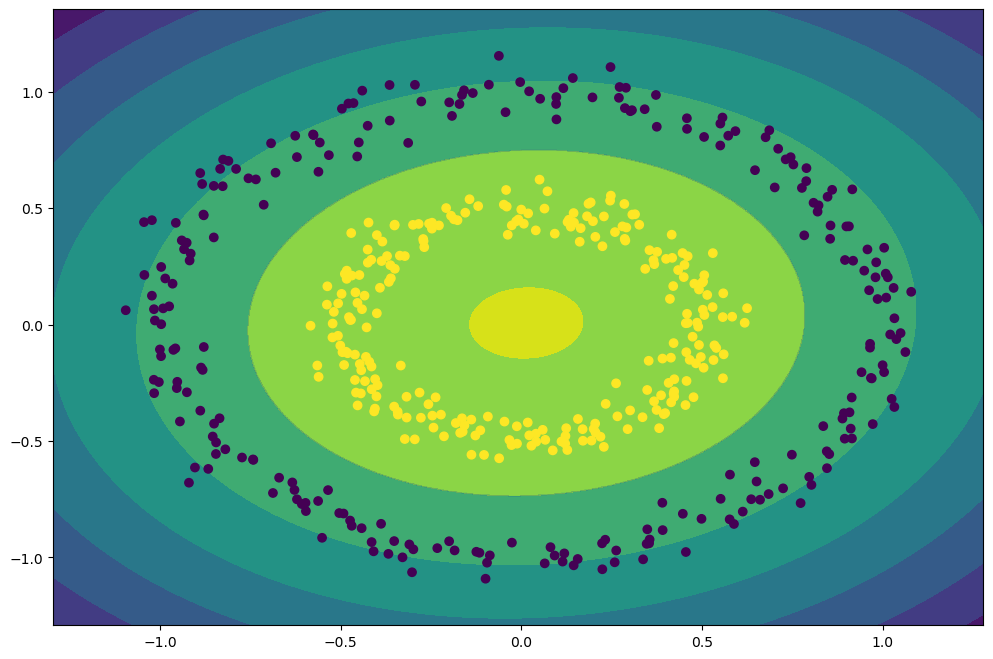

In [7]:
# A compléter ici
plotFrontiere2(X1, y1, model1, 1000, margin=0.2)

**Q5**: Si on entraîne ce modèle sur le jeu de données $X2, y2$, parvient-il à séparer les données ?

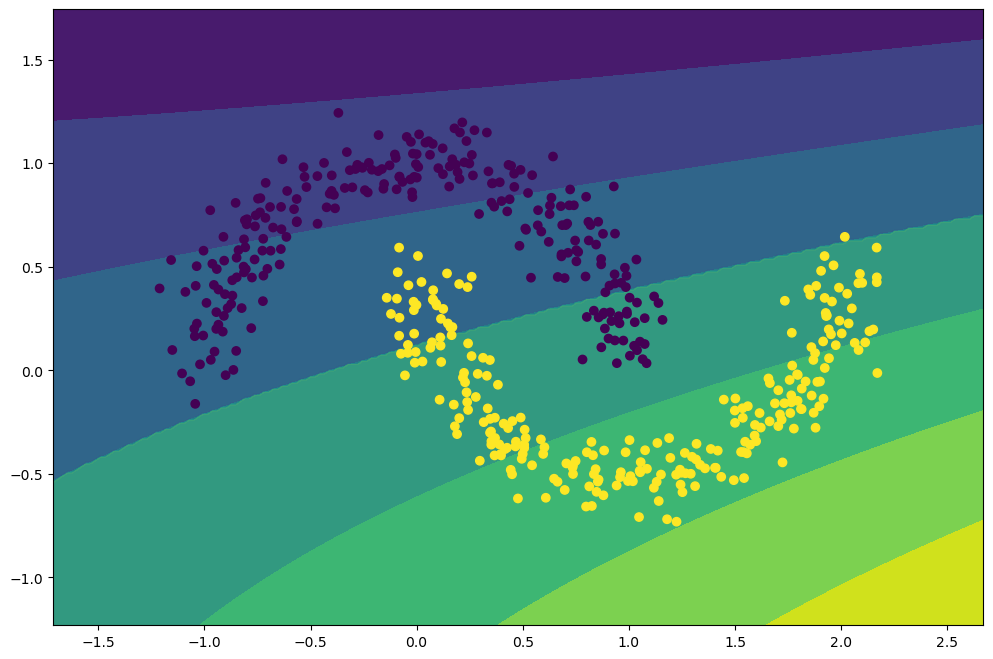

In [8]:
# A compléter ici
model2 = SVC(kernel="poly", degree=2, coef0=1.0, C=1.0)

model2.fit(X2, y2)

plotFrontiere2(X2, y2, model2, 200, margin=0.5)
# NON, il ne les separe pas du tout 

On va maintenant entraîner un modèle SVC avec noyau RBF (Radial Basis Function) sur  le deuxième jeu de données, et visualiser sa frontière de décision pour plusieurs valeurs de `gamma`, pour étudier l'influence de ce paramètre.

**Q6**:  Entraînez ce modèle sur $(X2, y2)$ plusieurs fois, avec des valeurs différentes de $\gamma$, par exemple $0.1, 1, 10$, et $100$. À chaque fois, affichez sa frontière de décision en utilisant `DecisionBoundaryDisplay`.

decision boundary with gamma = 0.1


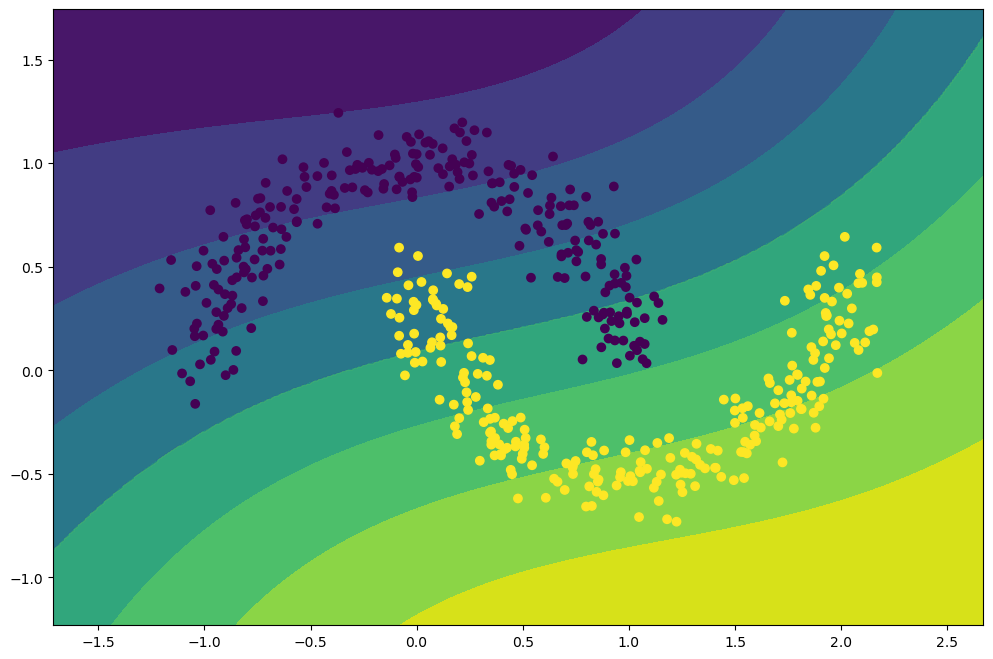

decision boundary with gamma = 1.0


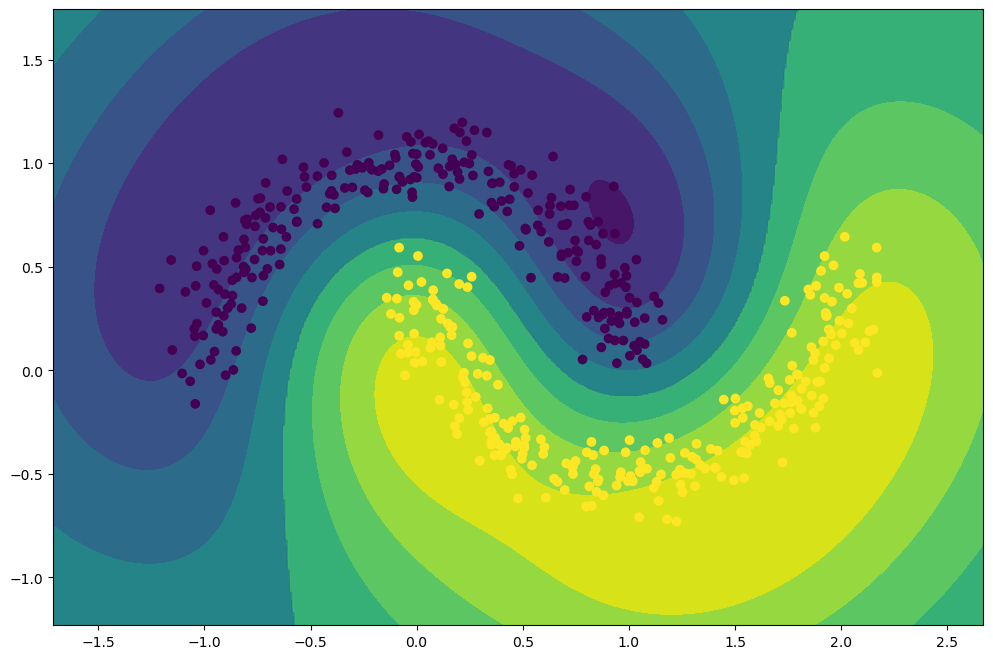

decision boundary with gamma = 10


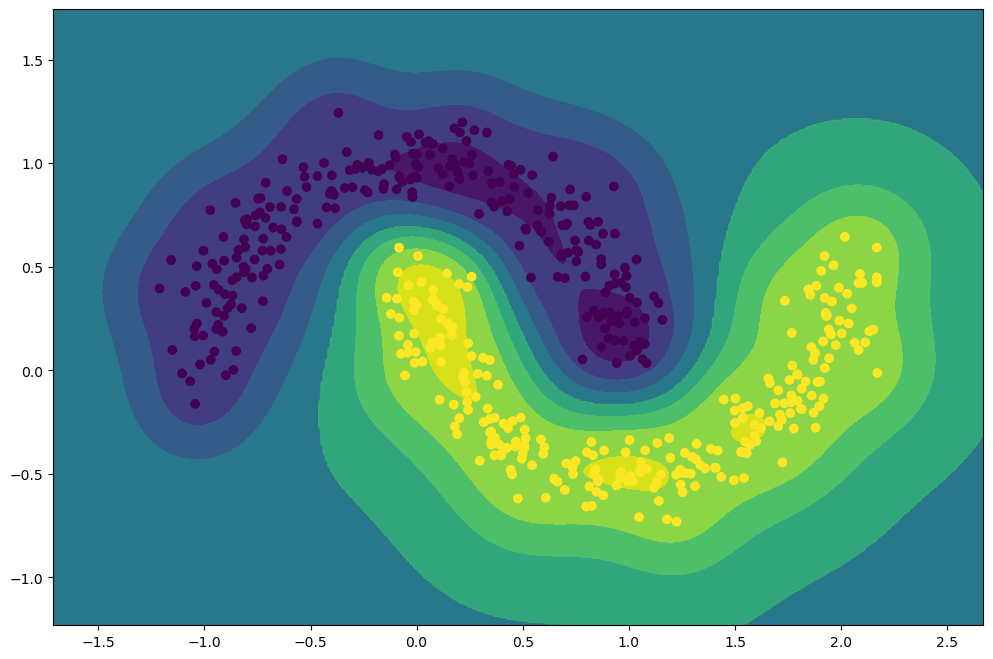

decision boundary with gamma = 100


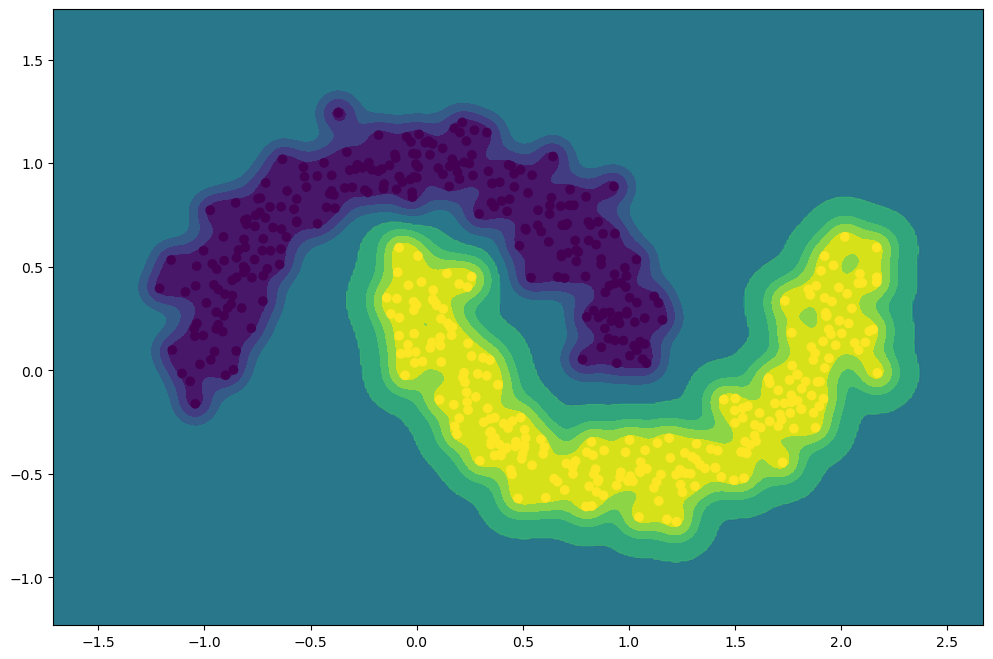

In [9]:
# A compléter ici
for gamma in (0.1, 1.0, 10, 100):
    model2 = SVC(kernel="rbf", gamma=gamma, coef0=1.0, C=1.0)
    model2.fit(X2, y2)
    print(f"decision boundary with {gamma = }")
    plotFrontiere2(X2, y2, model2, res=400, margin=0.5, alpha=0.4)
    plt.show()

**Q7**: Quel est l'impact du paramètres $\gamma$ sur le modèle ?

>  A compléter ici
plus le gamma est élevé plus la barriere vas etre précise (et inversement)
donc un gamma plus élevé vas permetre "d'overfit" plus 

## 2. Reconnaissance de chiffres manuscrits

Le jeu de données `digits` contient des images de 8 par 8 pixels, contenant chacune un unique chiffre, entre 0 et 9.
Sur ce jeu de données, l'objectif est d'identifier le chiffre à partir des pixels de l'image : il s'agit d'un problème de classification avec 10 classes (0, 1, ..., 9).

On commence par afficher quelques exemples d'images:

In [10]:
from sklearn.utils import Bunch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


digits: Bunch = load_digits()
X: np.ndarray = digits.data
y: np.ndarray = digits.target
classes = sorted(set(list(y)))
print(classes)
print(len(y))

#plt.gray()
#plt.matshow(digits.images[0])
#plt.show()
#print(y[0])

# Shuffle the data
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
1797


On va utiliser comme baseline un modèle de régression logistique sur les données standardisées.

**Q1**: Créez une pipeline composée d'un `StandardScaler` et d'une régression logistique. 
Evaluez sa précision à l'aide d'une cross-validation avec 5 répétitions. Quelle précision obtenez-vous en moyenne ?

In [11]:
# A compléter ici
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

model = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_val_score(model, X, y, cv=KFold(5), scoring="accuracy")
print(f"accuracy: {scores.mean():.3g} +/- {scores.std():.3g}")

accuracy: 0.964 +/- 0.00638


**Q2**: Quelle est la valeur par défaut de `gamma` dans `svm.SVC`?

In [12]:
print(SVC(kernel="rbf").get_params()["gamma"])

scale


> A compléter ici
la valeur par defaut est 'scale'<br>
soit calculé a: 1 / (n_features * X.var())

**Q3**: Entraînez un modèle SVC avec un kernel RBF (avec `gamma` par défaut) sur les données de digit. Quel score moyen obtenez-vous (sur une 5-fold CV) ?

In [13]:
# A compléter ici

model = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
scores = cross_val_score(model, X, y, cv=KFold(5), scoring="accuracy")
print(f"accuracy: {scores.mean():.3g} +/- {scores.std():.3g}")


accuracy: 0.979 +/- 0.00516


On veut maintenant chercher les valeurs de `gamma` et `C` qui nous permettront d'obtenir les meilleures performances possible.

**Q4**: En utilisant la méthode de votre choix (visuellement, avec `GridSearchCV` ou `RandomizedSearchCV`), cherchez les valeurs de `gamma` et `C` qui donnent le meilleur score possible. Quelles valeurs des paramètres et du score obtenez-vous ?

In [14]:
# A compléter ici
from sklearn.model_selection import GridSearchCV
# print(model.get_params(deep=True))
search = GridSearchCV(
    # model, param_grid={"svc__gamma": [0.05, 0.075, 0.1, 0.125], "svc__C": [0.85, 0.95, 1.0, 1.05, 1.15]}, 
    model, param_grid={"svc__gamma": np.linspace(0.0175, 0.025, num=7), "svc__C": np.linspace(0.95, 1.10, num=7)}, 
    cv=5, return_train_score=True, verbose=3, n_jobs=50, scoring="accuracy")
search.fit(X, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END svc__C=0.95, svc__gamma=0.0175;, score=(train=0.997, test=0.983) total time=   0.1s
[CV 3/5] END svc__C=0.95, svc__gamma=0.0175;, score=(train=0.997, test=0.975) total time=   0.2s
[CV 2/5] END svc__C=0.95, svc__gamma=0.0175;, score=(train=0.998, test=0.975) total time=   0.2s
[CV 5/5] END svc__C=0.95, svc__gamma=0.02;, score=(train=0.997, test=0.978) total time=   0.2s
[CV 4/5] END svc__C=0.95, svc__gamma=0.0175;, score=(train=0.997, test=0.989) total time=   0.3s
[CV 4/5] END svc__C=0.95, svc__gamma=0.018750000000000003;, score=(train=0.997, test=0.989) total time=   0.5s
[CV 5/5] END svc__C=0.95, svc__gamma=0.0175;, score=(train=0.997, test=0.975) total time=   0.1s
[CV 3/5] END svc__C=0.95, svc__gamma=0.02125;, score=(train=0.998, test=0.969) total time=   0.3s
[CV 5/5] END svc__C=0.95, svc__gamma=0.018750000000000003;, score=(train=0.997, test=0.975) total time=   0.3s
[CV 1/5] END svc__C=0.95, svc__gamma=0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=50,
             param_grid={'svc__C': array([0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ]),
                         'svc__gamma': array([0.0175 , 0.01875, 0.02   , 0.02125, 0.0225 , 0.02375, 0.025  ])},
             return_train_score=True, scoring='accuracy', verbose=3)

In [15]:
def printSearch(search):
    paramsSearched = search.cv_results_["params"]

    mean_test_score = search.cv_results_["mean_test_score"]
    std_test_score = search.cv_results_["std_test_score"]

    mean_train_scores = search.cv_results_["mean_train_score"]
    std_train_score = search.cv_results_["std_train_score"]

    indexes = sorted(range(len(paramsSearched)), key=lambda i:mean_test_score[i], reverse=True)

    for index in indexes:
        gamma = paramsSearched[index]["svc__gamma"]
        C = paramsSearched[index]["svc__C"]
        form1 = "<6.3g"
        form2 = "<6.3g"
        form3 = "<9.3g"
        print(f"{gamma=:{form1}} - {C=:{form1}} -> train: {mean_train_scores[index]:{form2}} +/- {std_train_score[index]:{form3}}", end="")
        print(f" || test: {mean_test_score[index]:{form2}} +/- {std_test_score[index]:{form3}}")
        

In [16]:
# gamma=0.01   - C=0.631  -> train: 0.991  +/- 0.000622  || test: 0.973  +/- 0.0108  
# gamma=0.0178 - C=0.631  -> train: 0.996  +/- 0.0015    || test: 0.976  +/- 0.00855
# gamma=0.016  - C=0.8    -> train: 0.997  +/- 0.000622  || test: 0.979  +/- 0.00759
# gamma=0.0192 - C=1      -> train: 0.997  +/- 0.000681  || test: 0.981  +/- 0.00528 
# -> tres bon
#   gamma=0.02   - C=1      -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
printSearch(search)


gamma=0.02   - C=1      -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.0188 - C=1.02   -> train: 0.997  +/- 0.000681  || test: 0.981  +/- 0.00528  
gamma=0.02   - C=1.02   -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.0188 - C=1.05   -> train: 0.997  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.02   - C=1.05   -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.0188 - C=1.08   -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.02   - C=1.08   -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.0188 - C=1.1    -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.02   - C=1.1    -> train: 0.998  +/- 0.000556  || test: 0.981  +/- 0.00528  
gamma=0.0175 - C=1.1    -> train: 0.997  +/- 0.000681  || test: 0.98   +/- 0.00593  
gamma=0.0188 - C=0.975  -> train: 0.997  +/- 0.000622  || test: 0.98   +/- 0.00539  
gamma=0.02   - C=0.975  -> train: 0.997  +/- 0.000556  || test: 0

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats._continuous_distns import uniform_gen, norm_gen, expon_gen
from math import log

search = RandomizedSearchCV(
    model, {"svc__gamma": uniform_gen(a=0.005, b=0.04),
            "svc__C": uniform_gen(a=0.8, b=1.15)},
    cv=5, return_train_score=True, n_iter=100, n_jobs=5, verbose=3, scoring="accuracy")
search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END svc__C=0.3507448407470112, svc__gamma=0.6254689324167458;, score=(train=0.103, test=0.100) total time=   0.2s
[CV 4/5] END svc__C=0.3507448407470112, svc__gamma=0.6254689324167458;, score=(train=0.203, test=0.111) total time=   0.2s
[CV 2/5] END svc__C=0.3507448407470112, svc__gamma=0.6254689324167458;, score=(train=0.205, test=0.103) total time=   0.2s
[CV 3/5] END svc__C=0.3507448407470112, svc__gamma=0.6254689324167458;, score=(train=0.203, test=0.106) total time=   0.2s
[CV 5/5] END svc__C=0.3507448407470112, svc__gamma=0.6254689324167458;, score=(train=0.104, test=0.100) total time=   0.2s
[CV 1/5] END svc__C=0.12956009202054042, svc__gamma=0.38908738552606925;, score=(train=0.102, test=0.100) total time=   0.2s
[CV 2/5] END svc__C=0.12956009202054042, svc__gamma=0.38908738552606925;, score=(train=0.203, test=0.103) total time=   0.2s
[CV 4/5] END svc__C=0.12956009202054042, svc__gamma=0.38908738552606925;

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=100, n_jobs=5,
                   param_distributions={'svc__C': <scipy.stats._continuous_distns.uniform_gen object at 0x7f41ace99990>,
                                        'svc__gamma': <scipy.stats._continuous_distns.uniform_gen object at 0x7f41a6e7b7d0>},
                   return_train_score=True, scoring='accuracy', verbose=3)

In [18]:
# gamma=0.0204 - C=0.409  -> train: 0.991  +/- 0.000941  || test: 0.972  +/- 0.00776 
printSearch(search)

gamma=0.0701 - C=0.703  -> train: 1      +/- 0         || test: 0.963  +/- 0.00817  
gamma=0.0703 - C=0.603  -> train: 1      +/- 0         || test: 0.96   +/- 0.00721  
gamma=0.066  - C=0.427  -> train: 0.998  +/- 0.00034   || test: 0.949  +/- 0.0093   
gamma=0.0642 - C=0.289  -> train: 0.992  +/- 0.00222   || test: 0.936  +/- 0.0105   
gamma=0.0813 - C=0.335  -> train: 0.995  +/- 0.000921  || test: 0.905  +/- 0.00652  
gamma=0.134  - C=0.997  -> train: 1      +/- 0         || test: 0.9    +/- 0.0146   
gamma=0.122  - C=0.759  -> train: 1      +/- 0         || test: 0.897  +/- 0.0144   
gamma=0.134  - C=0.874  -> train: 1      +/- 0         || test: 0.888  +/- 0.0136   
gamma=0.0736 - C=0.162  -> train: 0.946  +/- 0.00837   || test: 0.869  +/- 0.0145   
gamma=0.147  - C=0.885  -> train: 1      +/- 0         || test: 0.867  +/- 0.0115   
gamma=0.169  - C=0.969  -> train: 1      +/- 0         || test: 0.84   +/- 0.00989  
gamma=0.176  - C=0.997  -> train: 1      +/- 0         || test: 0

**Q4 bis** (facultatif): `GridSearchCV` ou `RandomizedSearchCV` peuvent chercher des paramètres pour plusieurs kernels différent en un seul appel: essayez d'autre types de kernel!

In [19]:
# A compléter ici (facultatif)

## 3. Détection d'intrus (outliers)

Les OCSVM sont des estimateurs de support de densité pour des données multidimensionnelles. L’idée derrière l’implémentation est de trouver l’hyperplan le plus éloigné de l’origine qui sépare les données de l’origine.

Dans scikit-learn, les One-Class SVM sont implémentés dans le module sklearn.svm, n’hésitez pas à consulter la documentation de ce module pour plus de détails. Nous utilisons un noyau gaussien pour faire la détection des outliers dans un échantillon de données en deux dimensions. Pour cet exemple, nous générons deux clusters gaussiens auxquels nous ajoutons 10% de données anormales, tirées au hasard uniformément dans l’espace à deux dimensions considéré :

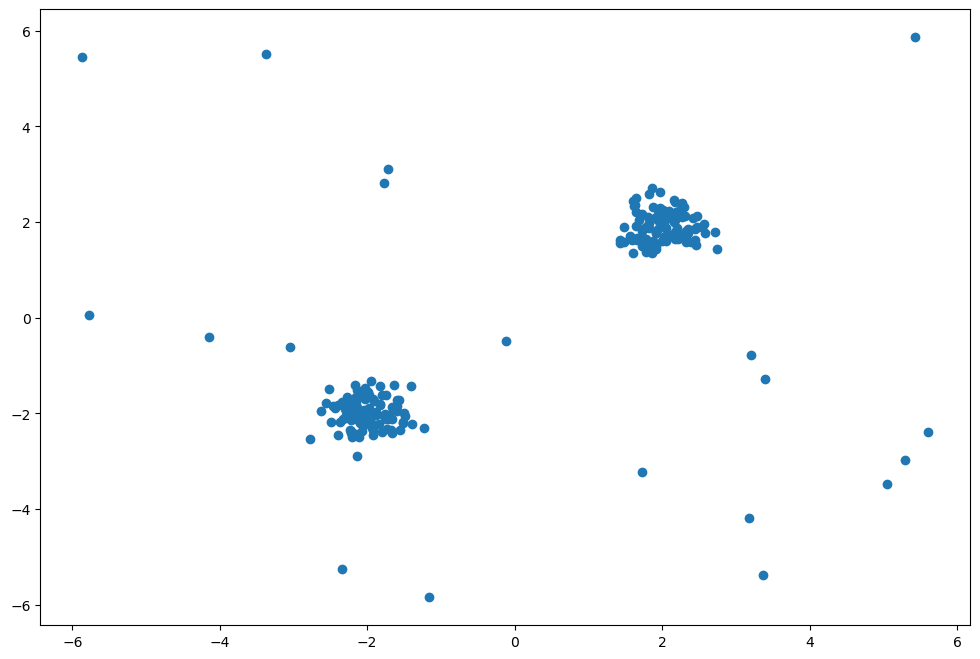

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm

# On créé deux groupes séparés (échantillons de gaussiennes)
N = 200
data1 = 0.3 * np.random.randn(N // 2, 2) + [2,2]
data2 = 0.3 * np.random.randn(N // 2, 2) - [2,2]

# On créé 10% de données anormales (*outliers*)
outliers = np.random.uniform(size=(N // 10, 2), low=-6, high=6)

# Les données = groupes + anomalies
X = np.concatenate((data1, data2, outliers))

plt.scatter(X[:,0], X[:,1]) and plt.show()

Nous pouvons ensuite créer le modèle de one-class SVM avec sklearn. Le paramètre nu correspond à la proportion maximale d’erreurs autorisées, c’est-à-dire au pourcentage maximal de points du jeu de données que l’on acceptera d’exclure de notre classe. Cette fraction doit peu ou prou correspondre au pourcentage de données anormales attendu dans le jeu de données. Dans notre cas, nous savons qu’il y a environ 10% d”outliers donc nous pouvons choisir nu=0.1.

In [21]:
# Construction du modèle (noyau RBF)
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05)
clf.fit(X)

OneClassSVM(gamma=0.05, nu=0.1)

Le code suivant permet alors de tracer les frontières (plus exactement les lignes de niveaux) de la fonction de décision de la OneClassSVM ainsi entraînée :

In [22]:
def run():
    # Afficher les points et les vecteurs les plus proches du plan de séparation
    xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    y_pred = clf.predict(X)

    # Choix du jeu de couleurs
    plt.set_cmap(plt.cm.coolwarm)
    # Trace le contour de la fonction de décision
    plt.contourf(xx, yy, Z)
    # Affiche les points considérés comme "inliers"
    plt.scatter(X[y_pred>0,0], X[y_pred>0,1], c='white', edgecolors='k', label='inliers')
    # Affiche les points considérés comme "outliers"
    plt.scatter(X[y_pred<=0,0], X[y_pred<=0,1], c='black', label='outliers')
    plt.legend()
    plt.show()

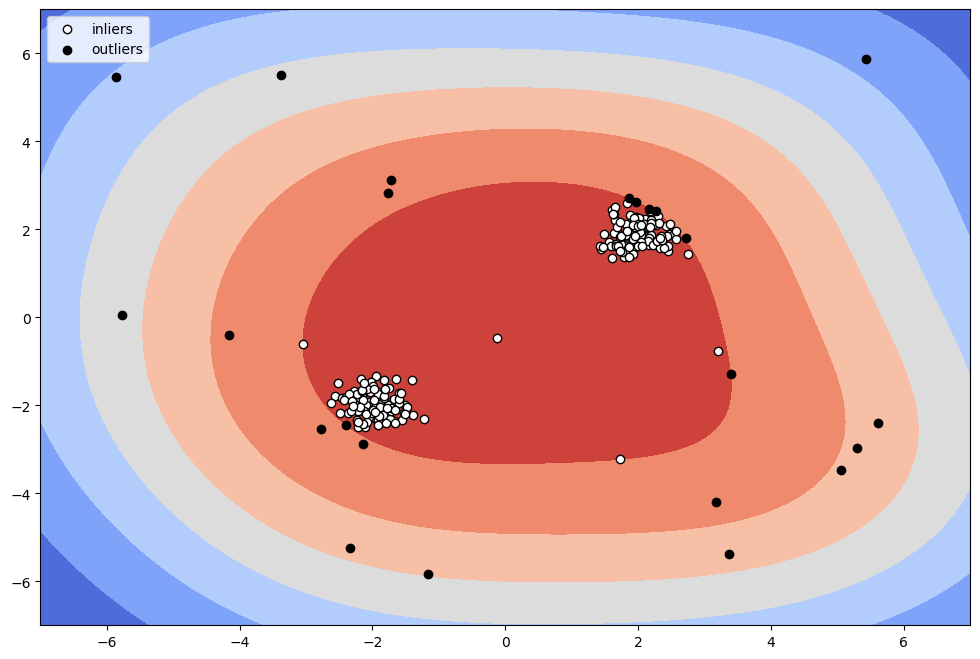

In [23]:
run()

**Q1**: Testez plusieurs valeurs pour le paramètre gamma. Pour quelle valeur le résultat semble meilleur (moins de outliers incorrectement classés) ?

En pratique on ne connait pas le nombre d'outliers, l’utilité des OCSVM est de les détecter. Le paramètre `nu` doit donc avoir une bonne valeur pour ne pas sous-estimer (ou sur-estimer) le support de la distribution.

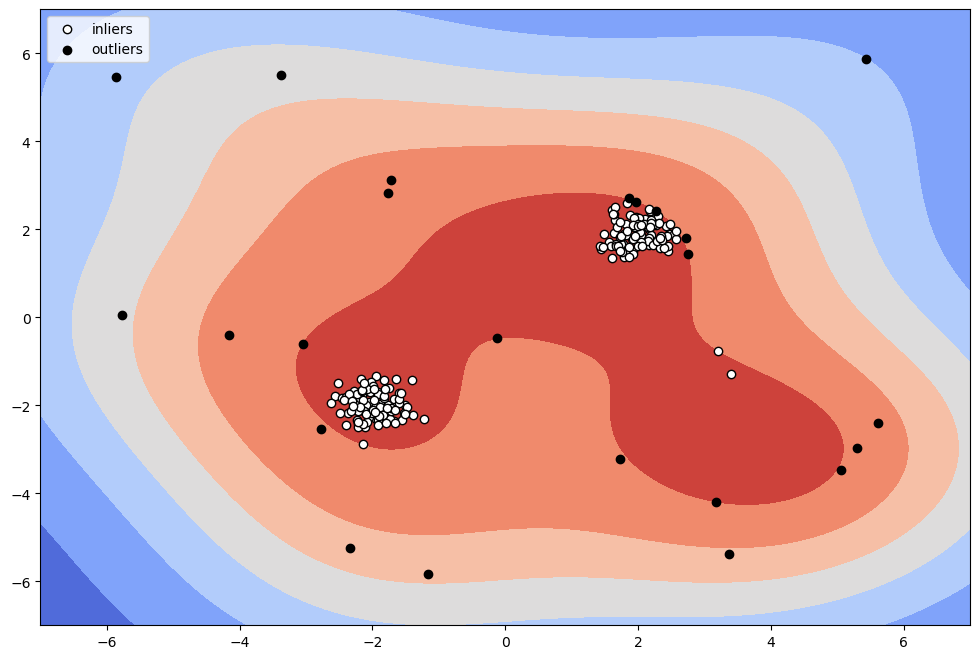

In [24]:
# A compléter ici
clf = svm.OneClassSVM(nu=0.10, kernel="rbf", gamma=0.09)
clf.fit(X)
run()

**Q2**: Remplacez le noyau `rbf` par un noyau linéaire. Quel problème constatez-vous ?

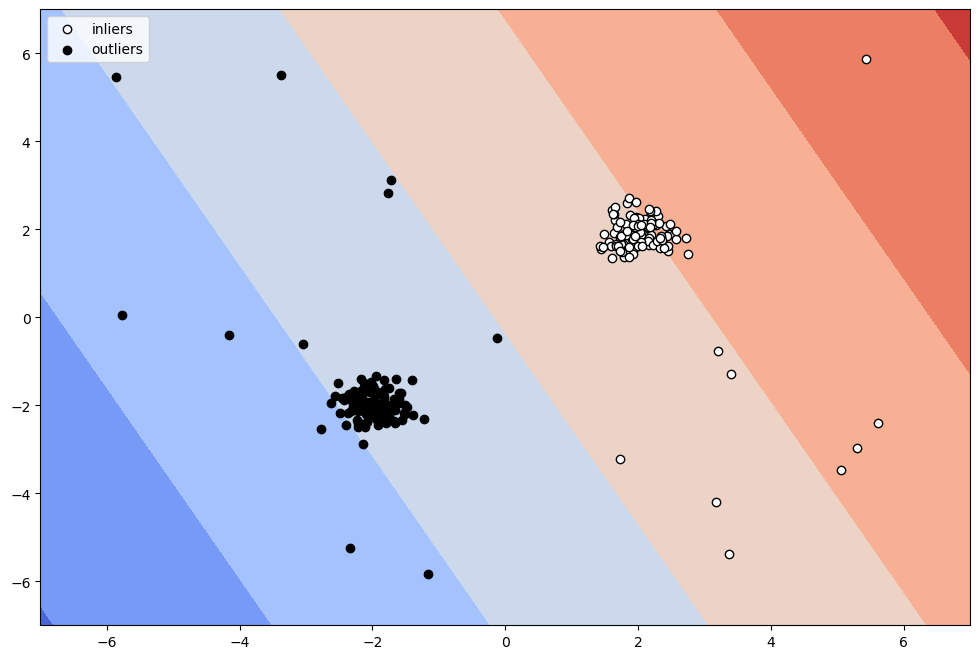

In [25]:
# A compléter ici
clf = svm.OneClassSVM(nu=0.10, kernel="linear")
clf.fit(X)
run()
# il est incapable de faire le groupement

## 4. Régression avec les SVM : SVR 

Dans le cas de la régression, l’objectif est d’apprendre un modèle qui prédit les valeurs d’une fonction à partir des valeurs des variables d’entrée. L’idée est de trouver la fonction la plus « lisse » qui passe par les (ou à proximité des) données d’apprentissage. Scikit-learn implémente le modèle SVR (epsilon-regression) dans le module Python `sklearn.svm.SVR` dont vous pouvez bien sûr consulter [la documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

Dans cette partie nous présenterons la régression dans le cas unidimensionnel en comparant plusieurs noyaux avec scikit-learn. Le module `sklearn.svm.SVR` permet de faire varier tous les paramètres.

Il faut d’abord importer les modules :

In [35]:
from sklearn.svm import SVR

### Données synthétiques

Dans un premier temps, nous allons travailler sur des données générées. Notre objectif sera de reproduire une sinusoïde bruitée :

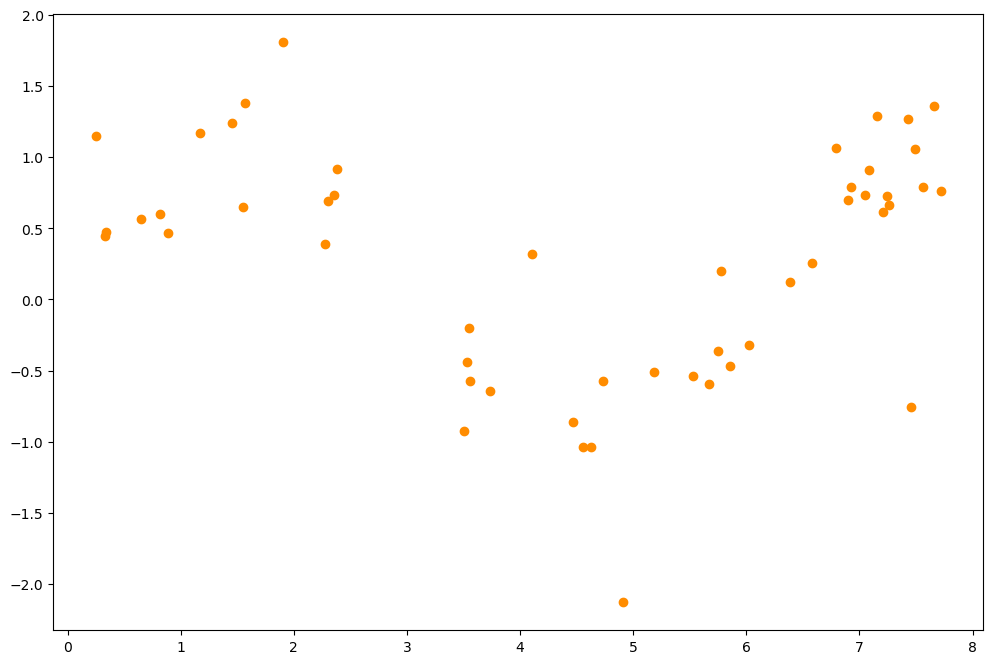

In [36]:
X = np.sort(8 * np.random.rand(50, 1), axis=0)
y = np.sin(X) * (0.5 + np.random.rand(50, 1))
y = y.ravel()
y[::5] += 3 * (0.5 - np.random.rand(10))
plt.scatter(X, y, color='darkorange', label='Données')
#plt.scatter(X, y)

Nous pouvons facilement entraîner trois modèles de SVM pour la régression grâce à la classe `SVR` de scikit-learn :

In [45]:
# Création des SVM
C = 1e0
svr_rbf = SVR(kernel='rbf', C=C, gamma=0.1)
svr_lin = SVR(kernel='linear', C=C)
svr_poly = SVR(kernel='poly', C=C, degree=2)

# Entraînement des SVM sur les observations bruitées
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

Visualisons les modèles : 

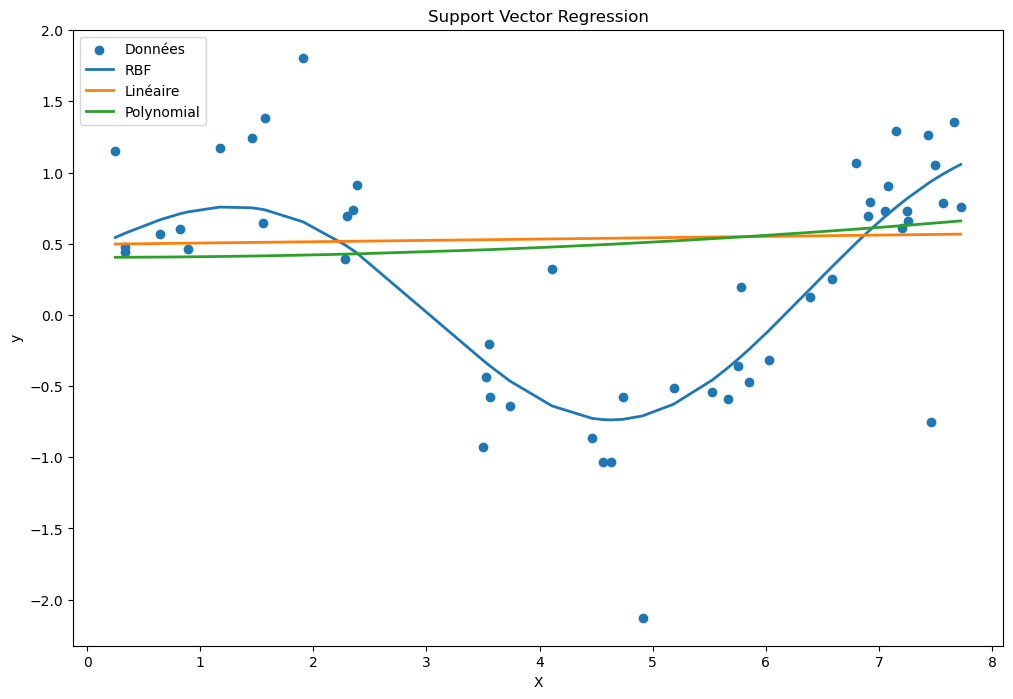

In [46]:
plt.scatter(X, y, label='Données')
plt.plot(X, y_rbf, lw=2, label='RBF')
plt.plot(X, y_lin, lw=2, label='Linéaire')
plt.plot(X, y_poly,lw=2, label='Polynomial')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

**Q1**: Que se passe-t-il si on prend une valeur de C beaucoup plus faible, par exemple $C = 0.1$ ?

Et si on prend une valeur beaucoup plus grande, comme $C = 1e6$ ?

> A compléter ici
avec C=0.1 on underfit beaucoup et avec C=1e6 on overfit <br>
pour un C $ \in [1, 1000]$ on est bon (pour le rbf seulement)

### Diabetes dataset

`sklearn` contient plusieurs jeux de données réels d’exemple. Concentrons-nous sur le jeu de données *Diabetes* consistant à prévoir la progression de la maladie (représentée par un indice quantitatif) à partir de différentes variables : âge, sexe, pression artérielle, [IMC](https://fr.wikipedia.org/wiki/Indice_de_masse_corporelle) et six valeurs de prélévements sanguins.

In [49]:
from sklearn.datasets import load_diabetes
import pandas as pd

diabetes: Bunch = load_diabetes(as_frame=True)

X,y = diabetes.data, diabetes.target

diabetes.frame

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


**Q2**: Faites une partition aléatoire en partie apprentissage et partie test (70% apprentissage, 30% test).
Construisez un modèle de SVM de régression sur cette base et calculez l’erreur quadratique moyenne sur l’ensemble de test (**attention**, cela demande de changer la fonction de score utilisée).
Utilisez `GridSearchCV` pour déterminer le meilleur noyau à utiliser (et ses paramètres).

Quel erreur quadratique obtenez-vous sur le jeu de données de test ?

> j'observe que l'erreur quadratique es raisonable mais elle est tres difficile a comparer due a l'échelle des valeures a prédire <br> 
> on a autour de -> train: 2.59e+03  +/- 43.5   || test: 2.91e+03  +/- 143

In [83]:
# A compléter ici
from sklearn.model_selection import train_test_split
from math import log10

model = make_pipeline(StandardScaler(), SVR(kernel="rbf"))

# print(model.get_params(deep=True))
search = GridSearchCV(
    model, param_grid={"svr__gamma": np.logspace(log10(0.02), log10(0.12), num=10), 
                       "svr__C": np.logspace(log10(10), log10(100), num=10)}, 
    cv=5, return_train_score=True, verbose=3, n_jobs=50, scoring="neg_mean_squared_error")
search.fit(X, y)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END svr__C=10.0, svr__gamma=0.020000000000000004;, score=(train=-2965.625, test=-3023.817) total time=   0.0s
[CV 4/5] END svr__C=10.0, svr__gamma=0.020000000000000004;, score=(train=-3043.866, test=-2898.360) total time=   0.0s
[CV 3/5] END svr__C=10.0, svr__gamma=0.020000000000000004;, score=(train=-2925.239, test=-3211.880) total time=   0.0s
[CV 2/5] END svr__C=10.0, svr__gamma=0.020000000000000004;, score=(train=-2964.402, test=-3044.754) total time=   0.0s
[CV 1/5] END svr__C=10.0, svr__gamma=0.024405698717456206;, score=(train=-2918.972, test=-3040.007) total time=   0.0s
[CV 5/5] END svr__C=10.0, svr__gamma=0.020000000000000004;, score=(train=-3000.178, test=-3218.074) total time=   0.0s
[CV 2/5] END svr__C=10.0, svr__gamma=0.029781906494362183;, score=(train=-2872.058, test=-2921.522) total time=   0.0s
[CV 2/5] END svr__C=10.0, svr__gamma=0.024405698717456206;, score=(train=-2919.588, test=-2980.381) tota

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=50,
             param_grid={'svr__C': array([ 10.        ,  12.91549665,  16.68100537,  21.5443469 ,
        27.82559402,  35.93813664,  46.41588834,  59.94842503,
        77.42636827, 100.        ]),
                         'svr__gamma': array([0.02      , 0.0244057 , 0.02978191, 0.03634241, 0.0443481 ,
       0.05411732, 0.06603854, 0.08058584, 0.09833769, 0.12      ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [94]:
def printSearch(search):
    paramsSearched = search.cv_results_["params"]

    mean_test_score = -search.cv_results_["mean_test_score"]
    std_test_score = search.cv_results_["std_test_score"]

    mean_train_scores = -search.cv_results_["mean_train_score"]
    std_train_score = search.cv_results_["std_train_score"]

    indexes = sorted(range(len(paramsSearched)), key=lambda i:mean_test_score[i], reverse=False)

    for index in indexes:
        gamma = paramsSearched[index]["svr__gamma"]
        C = paramsSearched[index]["svr__C"]
        form1 = "<6.3g"
        form2 = "<9.3g"
        form3 = "<6.3g"
        print(f"{gamma=:{form1}} - {C=:{form1}} -> train: {mean_train_scores[index]:{form2}} +/- {std_train_score[index]:{form3}}", end="")
        print(f" || test: {mean_test_score[index]:{form2}} +/- {std_test_score[index]:{form3}}")
    
print(f"expected output ranging as min:{y.min():.3g} | max:{y.max():.3g} | avg:{y.mean():.3g} | sd:{y.std():.3g}")
print(f"(max-min)^2 = {(y.max()-y.min())**2:.3g} | std^2 = {y.std()**2:.3g}")

expected output ranging as min:25 | max:346 | avg:152 | sd:77.1
(max-min)^2 = 1.03e+05 | std^2 = 5.94e+03


In [95]:
# gamma=0.0528 - C=15     -> train: 2.67e+03  +/- 49.6   || test: 2.93e+03  +/- 142   
# gamma=0.0443 - C=27.8   -> train: 2.59e+03  +/- 43.5   || test: 2.91e+03  +/- 143
printSearch(search)

gamma=0.0443 - C=27.8   -> train: 2.59e+03  +/- 43.5   || test: 2.91e+03  +/- 143   
gamma=0.0363 - C=35.9   -> train: 2.59e+03  +/- 40.6   || test: 2.91e+03  +/- 144   
gamma=0.0244 - C=35.9   -> train: 2.67e+03  +/- 40.5   || test: 2.91e+03  +/- 127   
gamma=0.0298 - C=46.4   -> train: 2.6e+03   +/- 39.7   || test: 2.91e+03  +/- 140   
gamma=0.02   - C=46.4   -> train: 2.68e+03  +/- 38.7   || test: 2.91e+03  +/- 132   
gamma=0.0298 - C=27.8   -> train: 2.67e+03  +/- 41.5   || test: 2.91e+03  +/- 125   
gamma=0.0244 - C=27.8   -> train: 2.71e+03  +/- 36.5   || test: 2.91e+03  +/- 122   
gamma=0.0443 - C=21.5   -> train: 2.63e+03  +/- 45.2   || test: 2.91e+03  +/- 140   
gamma=0.0363 - C=27.8   -> train: 2.63e+03  +/- 43.3   || test: 2.91e+03  +/- 137   
gamma=0.0244 - C=59.9   -> train: 2.61e+03  +/- 38.5   || test: 2.91e+03  +/- 138   
gamma=0.0244 - C=46.4   -> train: 2.64e+03  +/- 40.6   || test: 2.92e+03  +/- 132   
gamma=0.0443 - C=35.9   -> train: 2.55e+03  +/- 42     || test: 2

In [102]:
# A compléter ici
from sklearn.model_selection import train_test_split
from math import log10

model = make_pipeline(StandardScaler(), SVR(kernel="linear"))

# print(model.get_params(deep=True))
search = GridSearchCV(
    model, param_grid={"svr__C": np.logspace(log10(0.5), log10(5), num=35)}, 
    cv=5, return_train_score=True, verbose=1, n_jobs=50, scoring="neg_mean_squared_error")
search.fit(X, y)

def printSearch(search):
    paramsSearched = search.cv_results_["params"]

    mean_test_score = -search.cv_results_["mean_test_score"]
    std_test_score = search.cv_results_["std_test_score"]

    mean_train_scores = -search.cv_results_["mean_train_score"]
    std_train_score = search.cv_results_["std_train_score"]

    indexes = sorted(range(len(paramsSearched)), key=lambda i:mean_test_score[i], reverse=False)

    for index in indexes:
        C = paramsSearched[index]["svr__C"]
        form1 = "<6.3g"
        form2 = "<9.3g"
        form3 = "<6.3g"
        print(f"{C=:{form1}} -> train: {mean_train_scores[index]:{form2}} +/- {std_train_score[index]:{form3}}", end="")
        print(f" || test: {mean_test_score[index]:{form2}} +/- {std_test_score[index]:{form3}}")

printSearch(search)
# C=0.873  -> train: 2.91e+03  +/- 38.5   || test: 3.03e+03  +/- 141
# C=0.803  -> train: 2.91e+03  +/- 37.5   || test: 3.03e+03  +/- 139 


Fitting 5 folds for each of 35 candidates, totalling 175 fits
C=0.803  -> train: 2.91e+03  +/- 37.5   || test: 3.03e+03  +/- 139   
C=0.92   -> train: 2.91e+03  +/- 39     || test: 3.03e+03  +/- 142   
C=0.86   -> train: 2.91e+03  +/- 38.2   || test: 3.03e+03  +/- 141   
C=0.751  -> train: 2.92e+03  +/- 34.2   || test: 3.03e+03  +/- 140   
C=0.702  -> train: 2.92e+03  +/- 35.4   || test: 3.03e+03  +/- 132   
C=0.984  -> train: 2.91e+03  +/- 39.6   || test: 3.03e+03  +/- 147   
C=1.05   -> train: 2.91e+03  +/- 39.2   || test: 3.03e+03  +/- 151   
C=1.13   -> train: 2.91e+03  +/- 38.6   || test: 3.03e+03  +/- 153   
C=1.21   -> train: 2.9e+03   +/- 36.6   || test: 3.03e+03  +/- 158   
C=0.656  -> train: 2.92e+03  +/- 37.5   || test: 3.03e+03  +/- 125   
C=1.29   -> train: 2.9e+03   +/- 36.7   || test: 3.04e+03  +/- 161   
C=1.38   -> train: 2.9e+03   +/- 36.6   || test: 3.04e+03  +/- 162   
C=1.58   -> train: 2.9e+03   +/- 37.3   || test: 3.04e+03  +/- 160   
C=1.69   -> train: 2.9e+03  

In [107]:
# A compléter ici
from sklearn.model_selection import train_test_split
from math import log10

model = make_pipeline(StandardScaler(), SVR(kernel="poly"))

print(model.get_params(deep=True))
search = GridSearchCV(
    model, param_grid={
        "svr__coef0": np.logspace(log10(1.5), log10(10), num=5), 
        "svr__degree": [1, 2, 3], 
        "svr__C": np.logspace(log10(2), log10(4), num=7)}, 
    cv=5, return_train_score=True, verbose=1, n_jobs=50, scoring="neg_mean_squared_error")
search.fit(X, y)

def printSearch(search):
    paramsSearched = search.cv_results_["params"]

    mean_test_score = -search.cv_results_["mean_test_score"]
    std_test_score = search.cv_results_["std_test_score"]

    mean_train_scores = -search.cv_results_["mean_train_score"]
    std_train_score = search.cv_results_["std_train_score"]

    indexes = sorted(range(len(paramsSearched)), key=lambda i:mean_test_score[i], reverse=False)

    for index in indexes:
        C = paramsSearched[index]["svr__C"]
        c0 = paramsSearched[index]["svr__coef0"]
        deg = paramsSearched[index]["svr__degree"]
        form1 = "<5.3g"
        form2 = "<9.3g"
        form3 = "<6.3g"
        print(f"{deg=:{form1}} - {c0=:{form1}} - {C=:{form1}} -> train: {mean_train_scores[index]:{form2}} +/- {std_train_score[index]:{form3}}", end="")
        print(f" || test: {mean_test_score[index]:{form2}} +/- {std_test_score[index]:{form3}}")

printSearch(search)
# deg=2     - c0=1.78  - C=3.41  -> train: 2.71e+03  +/- 38.5   || test: 2.98e+03  +/- 127 
# deg=2     - c0=1.88  - C=2.92  -> train: 2.73e+03  +/- 41.9   || test: 2.97e+03  +/- 120 
# deg=2     - c0=2.41  - C=2     -> train: 2.76e+03  +/- 46     || test: 2.97e+03  +/- 114

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svr', SVR(kernel='poly'))], 'verbose': False, 'standardscaler': StandardScaler(), 'svr': SVR(kernel='poly'), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svr__C': 1.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'poly', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}
Fitting 5 folds for each of 105 candidates, totalling 525 fits
deg=2     - c0=3.87  - C=2.24  -> train: 2.74e+03  +/- 44.6   || test: 2.97e+03  +/- 145   
deg=2     - c0=2.41  - C=2     -> train: 2.76e+03  +/- 46     || test: 2.97e+03  +/- 114   
deg=2     - c0=2.41  - C=3.17  -> train: 2.72e+03  +/- 39.5   || test: 2.97e+03  +/- 146   
deg=2     - c0=2.41  - C=2.24  -> train: 2.75e+03  +/- 46.4   || test: 2.97e+03  +/- 118   
deg=2     - c0=3.87  - C=2     -> train: 2.75e+03  +/- 45.2   ||

# A. Références

- Documentation de Scikit-learn sur les SVM: https://scikit-learn.org/stable/api/sklearn.svm.html
- Cours de ML du CNAM: https://cedric.cnam.fr/vertigo/cours/ml2/index.html
